# 05. Scaling Laws

In this notebook, we'll explore the fascinating world of scaling laws for Large Language Models (LLMs). Scaling laws are empirical relationships that describe how a model's performance changes as we scale up its size, the amount of data it's trained on, or the computational budget.

We will focus on two main areas:
1.  **Data Scaling**: How much data do we need to train a model of a certain size? We'll start with the "Chinchilla" scaling law.
2.  **Hyperparameter Scaling**: How do we choose optimal hyperparameters like batch size and learning rate as we scale? We'll use an isoflop analysis, inspired by the methodology from papers like DeepSeek, to investigate this.


## 1. Data Scaling: The Chinchilla Rule

The Chinchilla paper from DeepMind (2022) made a significant finding: for optimal performance at a given compute budget, model size and the number of training tokens should be scaled equally. They found that the best-performing models were trained on approximately **20 tokens for every parameter** in the model.

This gives us a simple rule of thumb to estimate the amount of training data we need for a model of a given size.

Let's formalize this and visualize the relationship.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

def chinchilla_data_scaling(num_params):
    """
    Calculates the recommended number of training tokens based on the Chinchilla scaling law.
    
    Args:
        num_params (int): The number of parameters in the model.
        
    Returns:
        int: The recommended number of training tokens.
    """
    return 20 * num_params

# Let's test it for a few model sizes
params_1m = 1_000_000
params_1b = 1_000_000_000
params_7b = 7_000_000_000

tokens_1m = chinchilla_data_scaling(params_1m)
tokens_1b = chinchilla_data_scaling(params_1b)
tokens_7b = chinchilla_data_scaling(params_7b)

print(f"Model with 1M parameters should be trained on ~{tokens_1m / 1e9:.2f} billion tokens.")
print(f"Model with 1B parameters should be trained on ~{tokens_1b / 1e9:.2f} billion tokens.")
print(f"Model with 7B parameters should be trained on ~{tokens_7b / 1e9:.2f} billion tokens.")

Model with 1M parameters should be trained on ~0.02 billion tokens.
Model with 1B parameters should be trained on ~20.00 billion tokens.
Model with 7B parameters should be trained on ~140.00 billion tokens.


Now, let's plot this relationship to get a better visual understanding. We'll use a log-log scale, which is standard for visualizing scaling laws as they often follow power-law relationships (straight lines on a log-log plot).

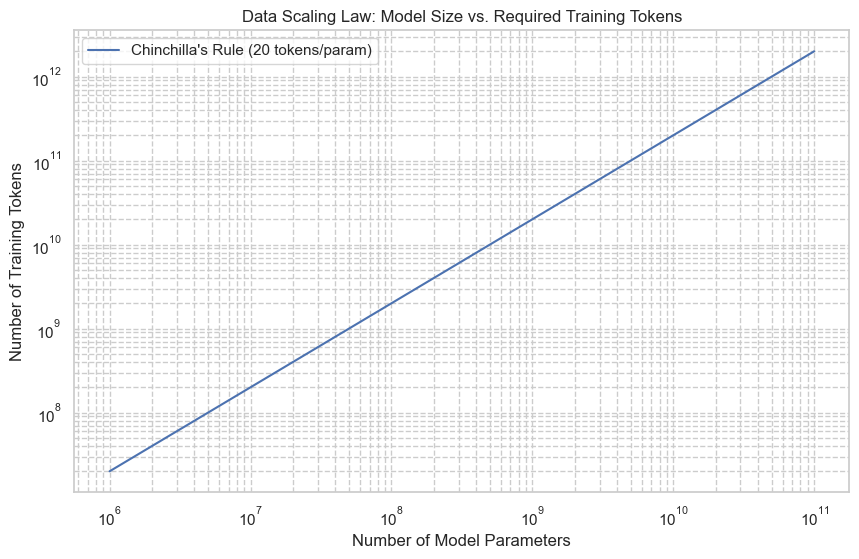

In [2]:
# Create a range of model sizes from 1M to 100B parameters
param_sizes = np.logspace(6, 11, num=100) # 10^6 to 10^11
required_tokens = [chinchilla_data_scaling(p) for p in param_sizes]

plt.figure(figsize=(10, 6))
plt.loglog(param_sizes, required_tokens, label="Chinchilla's Rule (20 tokens/param)")
plt.title("Data Scaling Law: Model Size vs. Required Training Tokens")
plt.xlabel("Number of Model Parameters")
plt.ylabel("Number of Training Tokens")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

## 2. Hyperparameter Scaling: Isoflop Analysis

Choosing the right hyperparameters (like learning rate and batch size) is crucial for efficient training. But how do the optimal values for these hyperparameters change as we scale our models and compute?

An **isoflop analysis** is a powerful technique to answer this. The core idea is to fix the total computational budget (measured in FLOPs - Floating Point Operations) and then run a series of experiments with different hyperparameter configurations to see which one achieves the lowest validation loss for that fixed budget.

This is exactly the methodology used in the DeepSeek paper to determine their learning rate and batch size schedules. They found that for a fixed compute budget, there's an optimal batch size and learning rate, and this optimum shifts as the compute budget changes.

### The Isoflop Contour Plot

The goal is to create a plot where:
- The x-axis is the Batch Size.
- The y-axis is the Learning Rate.
- The color/contour lines represent the final validation loss.

By looking at the "valley" in this contour plot, we can identify the combination of batch size and learning rate that is optimal for a given amount of compute.

### Our Experiment Setup

Actually running a full isoflop analysis is computationally very expensive, as it requires training dozens of models. For this notebook, we will simulate the *results* of such an analysis to demonstrate the concept. We'll generate data that mimics the typical shape of an isoflop contour plot.

We'll assume we ran an experiment for a model of a certain size, with a fixed compute budget of `C` FLOPs. We tried various batch sizes and learning rates and recorded the final validation loss for each run.

In [3]:
# Simulate the results of an isoflop analysis

# Define the hyperparameter ranges
batch_sizes = np.logspace(np.log2(512), np.log2(8192), num=10, base=2).astype(int)
learning_rates = np.logspace(-5, -3, num=10)

# Create a meshgrid for plotting
B, LR = np.meshgrid(batch_sizes, learning_rates)

# --- SIMULATED LOSS CALCULATION ---
# This function is a placeholder to generate a plausible-looking loss surface.
# In a real experiment, this would be the measured validation loss from a training run.
# The shape is designed to have a "valley" at an optimal point.
def simulate_loss(batch_size, learning_rate):
    # Let's assume the optimal point for this compute budget is around:
    # Batch Size = 2048, LR = 1e-4
    optimal_bs = 2048
    optimal_lr = 1.5e-4
    
    # Calculate loss based on distance from the optimum in log space
    log_bs_dist = (np.log(batch_size) - np.log(optimal_bs))**2
    log_lr_dist = (np.log(learning_rate) - np.log(optimal_lr))**2
    
    # A base loss and penalties for being non-optimal
    base_loss = 2.5
    loss = base_loss + 0.1 * log_bs_dist + 0.5 * log_lr_dist
    
    # Add some noise to make it look more realistic
    loss *= (1 + 0.05 * np.random.randn())
    
    return loss

# Generate the loss values for each combination of hyperparameters
losses = np.zeros_like(B, dtype=float)
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        losses[i, j] = simulate_loss(B[i, j], LR[i, j])

# Find the minimum loss and its corresponding hyperparameters
min_loss_val = np.min(losses)
min_idx = np.unravel_index(np.argmin(losses), losses.shape)
optimal_lr_found = LR[min_idx]
optimal_bs_found = B[min_idx]

print(f"Simulated Optimal Point:")
print(f"  - Batch Size: {optimal_bs_found}")
print(f"  - Learning Rate: {optimal_lr_found:.2e}")
print(f"  - Achieved Loss: {min_loss_val:.3f}")

Simulated Optimal Point:
  - Batch Size: 948
  - Learning Rate: 1.29e-04
  - Achieved Loss: 2.337


### Visualizing the Isoflop Contours

Now, let's create the log-log contour plot. This visualization is key to understanding the relationship between batch size, learning rate, and model performance for a fixed compute budget. The "sweet spot" will be the dark, low-loss region.

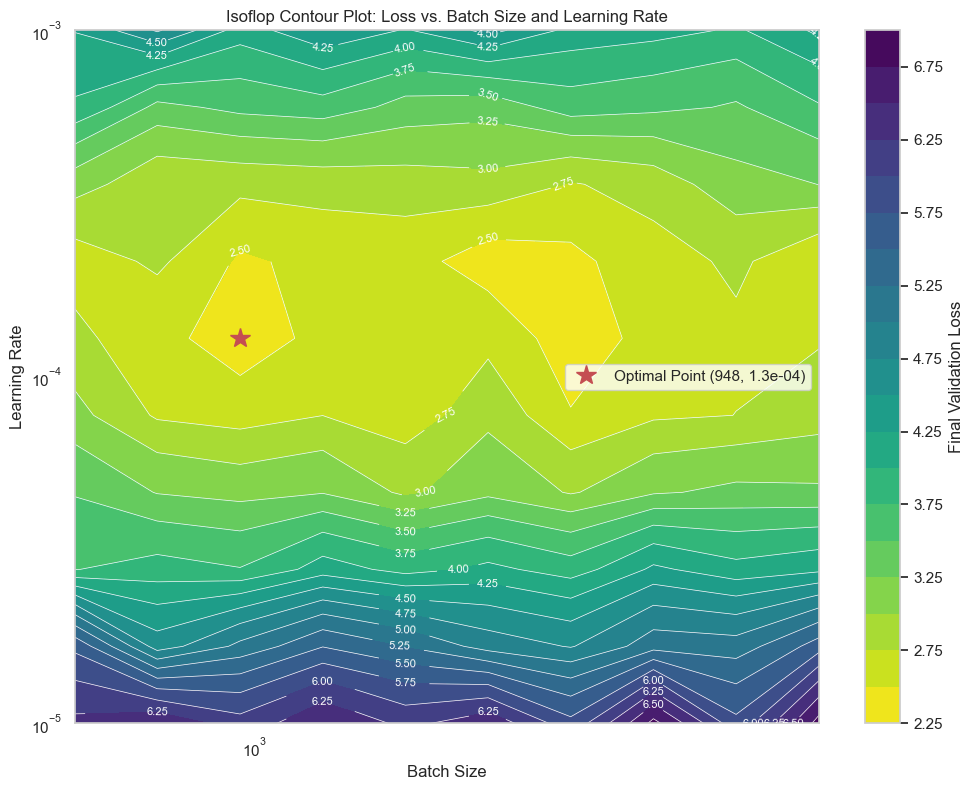

In [4]:
plt.figure(figsize=(12, 9))

# Create the contour plot
contour = plt.contourf(B, LR, losses, levels=20, cmap='viridis_r')
plt.colorbar(contour, label='Final Validation Loss')

# Add contour lines
contour_lines = plt.contour(B, LR, losses, levels=contour.levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')

# Mark the optimal point
plt.plot(optimal_bs_found, optimal_lr_found, 'r*', markersize=15, label=f'Optimal Point ({optimal_bs_found}, {optimal_lr_found:.1e})')

# Set log scales
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.title('Isoflop Contour Plot: Loss vs. Batch Size and Learning Rate')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Interpreting the Plot and Next Steps

The plot above is a powerful tool. It shows us that for a fixed computational budget:
- **If the batch size is too small or too large**, the performance degrades (loss increases).
- **If the learning rate is too low or too high**, the performance also degrades.
- There is an optimal region (the dark valley) where the combination of batch size and learning rate yields the best performance.

**How would we use this in practice?**

1.  **Choose a few compute budgets** (e.g., 1e18 FLOPs, 1e19 FLOPs, 1e20 FLOPs).
2.  **For each budget**, run a grid search over batch size and learning rate, training each model for that exact number of FLOPs.
3.  **Create an isoflop plot** for each compute budget.
4.  **Find the optimal (batch size, learning rate) pair** for each budget.
5.  **Plot the optimal hyperparameters against the compute budget**. This would give you a scaling law for your hyperparameters! For example, you might find that the optimal batch size grows as a power of the compute budget.

This empirical approach, while expensive, is how research labs derive the robust hyperparameter scaling laws that allow them to train massive models like GPT-4, Llama, and DeepSeek efficiently.


## 3. Scaling the Isoflop Analysis

The previous section showed how to find the optimal hyperparameters for a *single* model size and compute budget. But how do these optimal hyperparameters change as we scale the model itself?

To find this out, we need to repeat the isoflop analysis for several different model sizes. By tracking how the "optimal point" (the best batch size and learning rate) moves as the model size increases, we can derive a scaling law for the hyperparameters themselves.

### Simulating the Multi-Model Experiment

Once again, we'll simulate the results. We'll pretend we ran the analysis for three different model sizes:
- A small model (e.g., 10M parameters)
- A medium model (e.g., 100M parameters)
- A larger model (e.g., 1B parameters)

For each of these, we'll generate a simulated loss landscape and find its optimal point. We'll design the simulation so that the optimal batch size tends to increase with model size, which is a common finding in scaling law research.


In [10]:
import tiktoken
from src.shraygpt import ShrayGPT
tokenizer = tiktoken.get_encoding("r50k_base")

vocab_size = tokenizer.n_vocab
block_size = 1024
d_model = 32*32
n_head = 32
d_head = 32
n_layers = 2
learning_rate = 1e-6
num_experts = 8
num_experts_per_tok = 2
aux_loss_weight = 1e-2

def get_total_param_count(module):
    return sum(p.numel() for p in module.parameters())

configs = {
    "Small": {
        "d_model": 512,
        "n_head": 8,
        "n_layers": 6,
        "num_experts": 4,
        "num_experts_per_tok": 1
    },
    "Medium": {
        "d_model": 1024,
        "n_head": 16,
        "n_layers": 12,
        "num_experts": 8,
        "num_experts_per_tok": 2
    },
    "Large": {
        "d_model": 2048,
        "n_head": 32,
        "n_layers": 24,
        "num_experts": 16,
        "num_experts_per_tok": 2
    }
}

for type, config in configs.items():
    model = ShrayGPT(vocab_size, block_size, 
                     config['d_model'], config['n_head'], 
                     config['d_model'] // config['n_head'], 
                     config['n_layers'], 
                     config['num_experts'], config['num_experts_per_tok'],)
    print(f"{type} Model has {get_total_param_count(model):,} parameters.")

{'d_model': 512, 'n_head': 8, 'n_layers': 6} Model has 175,517,184 parameters.
{'d_model': 1024, 'n_head': 16, 'n_layers': 12} Model has 1,066,920,960 parameters.
{'d_model': 2048, 'n_head': 32, 'n_layers': 24} Model has 7,804,065,792 parameters.


In [ ]:
from scipy.optimize import curve_fit

# We need to import the ShrayGPT model to get its parameter count
# Note: We are not actually training it here, just using the class definition for parameter calculation
, Config

# --- SIMULATION FOR MULTIPLE MODEL SIZES ---

# Define the model sizes we will simulate (in parameters)





model_param_sizes = [10e6, 100e6, 1e9] 
model_configs = [
    Config(n_layer=4, n_head=4, n_embd=512),      # ~10M params
    Config(n_layer=12, n_head=8, n_embd=768),     # ~100M params
    Config(n_layer=24, n_head=16, n_embd=1280),   # ~1B params
]


# Store the optimal points we find for each model size
optimal_hyperparams = []

# This function now simulates loss based on model size
def simulate_loss_for_model(batch_size, learning_rate, model_params):
    # The optimal batch size now scales with the model size.
    # This is a common heuristic: larger models benefit from larger batches.
    # We'll model this as a power law: optimal_bs = k * (model_params)^a
    optimal_bs = 512 * (model_params / 10e6)**0.3 
    
    # Let's assume the optimal learning rate decreases slightly
    optimal_lr = 3e-4 * (model_params / 10e6)**-0.1

    log_bs_dist = (np.log(batch_size) - np.log(optimal_bs))**2
    log_lr_dist = (np.log(learning_rate) - np.log(optimal_lr))**2
    
    # Base loss also improves with model size
    base_loss = 2.8 * (model_params / 10e6)**-0.05
    loss = base_loss + 0.1 * log_bs_dist + 0.5 * log_lr_dist
    loss *= (1 + 0.05 * np.random.randn())
    
    return loss

# Loop through each model size and run a simulated isoflop analysis
for i, params in enumerate(model_param_sizes):
    config = model_configs[i]
    model = ShrayGPT(config)
    actual_params = sum(p.numel() for p in model.parameters())
    
    print(f"--- Simulating for model with ~{params/1e6:.0f}M parameters (Actual: {actual_params/1e6:.2f}M) ---")
    
    # Generate the loss values for this model size
    losses = np.zeros_like(B, dtype=float)
    for r in range(len(learning_rates)):
        for c in range(len(batch_sizes)):
            losses[r, c] = simulate_loss_for_model(B[r, c], LR[r, c], actual_params)

    # Find the minimum loss and its corresponding hyperparameters
    min_loss_val = np.min(losses)
    min_idx = np.unravel_index(np.argmin(losses), losses.shape)
    optimal_lr_found = LR[min_idx]
    optimal_bs_found = B[min_idx]
    
    print(f"  - Simulated Optimal BS: {optimal_bs_found}")
    print(f"  - Simulated Optimal LR: {optimal_lr_found:.2e}")
    print(f"  - Simulated Best Loss: {min_loss_val:.3f}\n")
    
    optimal_hyperparams.append({
        'params': actual_params,
        'batch_size': optimal_bs_found,
        'lr': optimal_lr_found
    })

# Convert to a more usable format
optimal_params = np.array([d['params'] for d in optimal_hyperparams])
optimal_batch_sizes = np.array([d['batch_size'] for d in optimal_hyperparams])
optimal_lrs = np.array([d['lr'] for d in optimal_hyperparams])

ImportError: cannot import name 'Config' from 'src.shraygpt' (c:\Users\SHRESHTH\Desktop\llms-from-scratch\src\shraygpt.py)

### Visualizing the Shifting Optimum

Now we can plot the isoflop contours for each model size. You will see the `*` marker, representing the optimal point, move as the model size increases. This movement is the scaling law we are trying to capture.

In [ ]:
fig, axes = plt.subplots(1, len(model_param_sizes), figsize=(20, 6), sharey=True)
fig.suptitle('Isoflop Contours for Different Model Sizes', fontsize=16)

for i, result in enumerate(optimal_hyperparams):
    ax = axes[i]
    params = result['params']
    
    # Regenerate the loss surface for plotting
    losses = np.zeros_like(B, dtype=float)
    for r in range(len(learning_rates)):
        for c in range(len(batch_sizes)):
            losses[r, c] = simulate_loss_for_model(B[r, c], LR[r, c], params)
    
    contour = ax.contourf(B, LR, losses, levels=15, cmap='viridis_r')
    
    # Mark the optimal point
    ax.plot(result['batch_size'], result['lr'], 'r*', markersize=15, label='Optimal Point')
    
    ax.set_title(f'~{params/1e6:.0f}M Parameters')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Batch Size')
    if i == 0:
        ax.set_ylabel('Learning Rate')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Deriving and Extrapolating the Scaling Law

We have collected the optimal batch sizes and learning rates for our simulated models. The final step is to plot these optimal points against their corresponding model sizes and fit a line to them. Since scaling laws are typically power laws, we'll use a log-log plot. A power law of the form `y = k * x^a` becomes a straight line on a log-log plot: `log(y) = log(k) + a * log(x)`.

We can use linear regression on the log-transformed data to find the exponent `a` and the constant `k`. This gives us a formula to predict the optimal hyperparameters for any model size, including a 7B parameter model.

In [5]:

# Define the power-law function we want to fit
def power_law(x, a, b):
    return a * x**b

# --- Fit for Batch Size ---
# Fit in log space, which is equivalent to fitting a power law
log_params = np.log(optimal_params)
log_bs = np.log(optimal_batch_sizes)
bs_coeffs = np.polyfit(log_params, log_bs, 1)
bs_exponent = bs_coeffs[0]
bs_const = np.exp(bs_coeffs[1])

# --- Fit for Learning Rate ---
log_lr = np.log(optimal_lrs)
lr_coeffs = np.polyfit(log_params, log_lr, 1)
lr_exponent = lr_coeffs[0]
lr_const = np.exp(lr_coeffs[1])

print(f"Batch Size Scaling Law: BS = {bs_const:.2f} * (Params)^{bs_exponent:.2f}")
print(f"Learning Rate Scaling Law: LR = {lr_const:.2e} * (Params)^{lr_exponent:.2f}")

# --- Extrapolate to a 7B Parameter Model ---
params_7b = 7e9
predicted_bs_7b = bs_const * (params_7b ** bs_exponent)
predicted_lr_7b = lr_const * (params_7b ** lr_exponent)

print(f"\n--- Predictions for a 7B Parameter Model ---")
print(f"  - Predicted Optimal Batch Size: {predicted_bs_7b:.0f}")
print(f"  - Predicted Optimal Learning Rate: {predicted_lr_7b:.2e}")


# --- Plotting the results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Hyperparameter Scaling Laws and Extrapolation', fontsize=16)

# Plot for Batch Size
ax1.loglog(optimal_params, optimal_batch_sizes, 'o', label='Simulated Optimal Points', markersize=10)
fit_params = np.logspace(np.log10(min(optimal_params)), np.log10(params_7b*1.1), 100)
ax1.loglog(fit_params, bs_const * fit_params**bs_exponent, 'r--', label=f'Fit: y={bs_const:.2f}*x^{bs_exponent:.2f}')
ax1.loglog(params_7b, predicted_bs_7b, 'g*', markersize=15, label=f'7B Prediction: {predicted_bs_7b:.0f}')
ax1.set_title('Batch Size vs. Model Size')
ax1.set_xlabel('Number of Parameters')
ax1.set_ylabel('Optimal Batch Size')
ax1.grid(True, which="both", ls="--")
ax1.legend()

# Plot for Learning Rate
ax2.loglog(optimal_params, optimal_lrs, 'o', label='Simulated Optimal Points', markersize=10)
ax2.loglog(fit_params, lr_const * fit_params**lr_exponent, 'r--', label=f'Fit: y={lr_const:.2e}*x^{lr_exponent:.2f}')
ax2.loglog(params_7b, predicted_lr_7b, 'g*', markersize=15, label=f'7B Prediction: {predicted_lr_7b:.2e}')
ax2.set_title('Learning Rate vs. Model Size')
ax2.set_xlabel('Number of Parameters')
ax2.set_ylabel('Optimal Learning Rate')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'optimal_params' is not defined